In [1]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tqdm import tqdm
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/owen/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/Users/owen/Desktop/q/daixie/.venv/lib/python3.13/site-packages/filterpy/common/helpers.py:364: SyntaxWarning: invalid escape sequence '\S'
  """


## Q1

In [15]:
!yt-dlp -f mp4 "https://www.youtube.com/shorts/MwxxofLNpTg?feature=share" -o "drone_video.mp4"
!yt-dlp -f mp4 "https://youtu.be/HYSdFHQDDcs" -o "traffic.mp4"

[youtube] Extracting URL: https://www.youtube.com/shorts/MwxxofLNpTg?feature=share
[youtube] MwxxofLNpTg: Downloading webpage
[youtube] MwxxofLNpTg: Downloading tv client config
[youtube] MwxxofLNpTg: Downloading player 6b3caec8
[youtube] MwxxofLNpTg: Downloading tv player API JSON
[youtube] MwxxofLNpTg: Downloading ios player API JSON
[youtube] MwxxofLNpTg: Downloading m3u8 information
[info] MwxxofLNpTg: Downloading 1 format(s): 18
[download] drone_video.mp4 has already been downloaded
[download] 100% of    1.21MiB
[youtube] Extracting URL: https://youtu.be/HYSdFHQDDcs
[youtube] HYSdFHQDDcs: Downloading webpage
[youtube] HYSdFHQDDcs: Downloading tv client config
[youtube] HYSdFHQDDcs: Downloading player 6b3caec8
[youtube] HYSdFHQDDcs: Downloading tv player API JSON
[youtube] HYSdFHQDDcs: Downloading ios player API JSON
[youtube] HYSdFHQDDcs: Downloading m3u8 information
[info] HYSdFHQDDcs: Downloading 1 format(s): 18
[download] Destination: traffic.mp4
[download] 100% of  990.41KiB i

In [11]:
model = YOLO('yolov8m.pt') 
def car_detection(video_path, output_path, confidence=0.3):
    """
    
    Args:
        video_path: Path to the input video
        output_path: Path to save the output video
        confidence: Detection confidence threshold
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    centroids = []
    frame_indices = []
    
    prev_detection = None
    detection_persistence = 0
    max_persistence = 3
    
    for frame_idx in tqdm(range(frame_count)):
        ret, frame = cap.read()
        if not ret:
            break
        
        annotated_frame = frame.copy()
        
        # Run detection - including vehicle classes
        results = model(frame, conf=confidence, classes=[2, 5, 7, 3])
        
        # Current detection flag
        detection_found = False
        current_centroid = None
        
        if len(results) > 0 and len(results[0].boxes) > 0:
            # Process results
            result = results[0]
            
            best_detection = None
            best_confidence = 0
            
            for box in result.boxes:
                conf = float(box.conf[0])
                cls = int(box.cls[0])
                
                if conf > best_confidence:
                    best_confidence = conf
                    best_detection = box
            
            if best_detection is not None:
                # Get box coordinates
                x1, y1, x2, y2 = map(int, best_detection.xyxy[0])
                
                # Calculate centroid
                centroid_x = (x1 + x2) // 2
                centroid_y = (y1 + y2) // 2
                
                if prev_detection is not None:
                    prev_x1, prev_y1, prev_x2, prev_y2 = prev_detection
                    
                    # Apply simple temporal smoothing (average with previous detection)
                    x1 = int(0.7 * x1 + 0.3 * prev_x1)
                    y1 = int(0.7 * y1 + 0.3 * prev_y1)
                    x2 = int(0.7 * x2 + 0.3 * prev_x2)
                    y2 = int(0.7 * y2 + 0.3 * prev_y2)
                    
                    # Recalculate centroid
                    centroid_x = (x1 + x2) // 2
                    centroid_y = (y1 + y2) // 2
                
                # Draw bounding box
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Draw centroid
                cv2.circle(annotated_frame, (centroid_x, centroid_y), 5, (0, 0, 255), -1)
                
                cv2.putText(annotated_frame, f"Conf: {best_confidence:.2f}", (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                current_centroid = (centroid_x, centroid_y)
                prev_detection = (x1, y1, x2, y2)
                detection_found = True
                detection_persistence = max_persistence 
        
        if not detection_found and prev_detection is not None and detection_persistence > 0:
            x1, y1, x2, y2 = prev_detection
            centroid_x = (x1 + x2) // 2
            centroid_y = (y1 + y2) // 2
            
            dash_length = 5
            for i in range(0, x2-x1, dash_length*2):
                cv2.line(annotated_frame, (x1+i, y1), (x1+i+dash_length, y1), (0, 255, 255), 2)
                cv2.line(annotated_frame, (x1+i, y2), (x1+i+dash_length, y2), (0, 255, 255), 2)
            for i in range(0, y2-y1, dash_length*2):
                cv2.line(annotated_frame, (x1, y1+i), (x1, y1+i+dash_length), (0, 255, 255), 2)
                cv2.line(annotated_frame, (x2, y1+i), (x2, y1+i+dash_length), (0, 255, 255), 2)
            
            cv2.circle(annotated_frame, (centroid_x, centroid_y), 5, (0, 255, 255), -1)
            
            cv2.putText(annotated_frame, f"Persistence: {detection_persistence}", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
            
            current_centroid = (centroid_x, centroid_y)
            detection_persistence -= 1
        
        centroids.append(current_centroid)
        if current_centroid is not None:
            frame_indices.append(frame_idx)
        
        out.write(annotated_frame)
    
    cap.release()
    out.release()
    
    return centroids, frame_indices, fps

centroids, frame_indices, fps = car_detection('drone_video.mp4', 'q1.mp4', confidence=0.3)



  0%|          | 0/451 [00:00<?, ?it/s]


0: 640x384 1 truck, 62.1ms
Speed: 0.9ms preprocess, 62.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  0%|          | 1/451 [00:00<01:01,  7.37it/s]


0: 640x384 1 car, 1 truck, 76.7ms
Speed: 0.5ms preprocess, 76.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 bus, 1 truck, 60.0ms
Speed: 0.6ms preprocess, 60.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  1%|          | 3/451 [00:00<00:39, 11.26it/s]


0: 640x384 1 car, 1 truck, 59.0ms
Speed: 0.6ms preprocess, 59.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 61.2ms
Speed: 0.9ms preprocess, 61.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  1%|          | 5/451 [00:00<00:34, 13.07it/s]


0: 640x384 1 car, 1 truck, 61.8ms
Speed: 0.5ms preprocess, 61.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 61.4ms
Speed: 0.7ms preprocess, 61.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


  2%|▏         | 7/451 [00:00<00:31, 13.90it/s]


0: 640x384 1 truck, 63.0ms
Speed: 0.6ms preprocess, 63.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 62.6ms
Speed: 0.5ms preprocess, 62.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


  2%|▏         | 9/451 [00:00<00:31, 14.23it/s]


0: 640x384 1 car, 1 truck, 61.1ms
Speed: 0.5ms preprocess, 61.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 60.8ms
Speed: 0.6ms preprocess, 60.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  2%|▏         | 11/451 [00:00<00:30, 14.59it/s]


0: 640x384 1 car, 1 truck, 60.1ms
Speed: 0.5ms preprocess, 60.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 64.5ms
Speed: 0.7ms preprocess, 64.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  3%|▎         | 13/451 [00:00<00:29, 14.70it/s]


0: 640x384 1 car, 64.5ms
Speed: 0.7ms preprocess, 64.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 61.9ms
Speed: 0.6ms preprocess, 61.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


  3%|▎         | 15/451 [00:01<00:29, 14.70it/s]


0: 640x384 1 truck, 56.9ms
Speed: 0.5ms preprocess, 56.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 58.1ms
Speed: 0.5ms preprocess, 58.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  4%|▍         | 17/451 [00:01<00:28, 15.15it/s]


0: 640x384 1 car, 1 truck, 56.4ms
Speed: 0.5ms preprocess, 56.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 58.2ms
Speed: 0.5ms preprocess, 58.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  4%|▍         | 19/451 [00:01<00:27, 15.51it/s]


0: 640x384 1 car, 56.1ms
Speed: 0.4ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 55.0ms
Speed: 0.5ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  5%|▍         | 21/451 [00:01<00:27, 15.90it/s]


0: 640x384 1 car, 57.3ms
Speed: 0.5ms preprocess, 57.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 57.3ms
Speed: 0.4ms preprocess, 57.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  5%|▌         | 23/451 [00:01<00:26, 16.03it/s]


0: 640x384 1 car, 1 truck, 60.2ms
Speed: 0.4ms preprocess, 60.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 75.6ms
Speed: 0.4ms preprocess, 75.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


  6%|▌         | 25/451 [00:01<00:27, 15.32it/s]


0: 640x384 1 car, 1 truck, 57.7ms
Speed: 0.5ms preprocess, 57.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 60.0ms
Speed: 0.4ms preprocess, 60.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  6%|▌         | 27/451 [00:01<00:27, 15.52it/s]


0: 640x384 1 car, 1 truck, 55.4ms
Speed: 0.4ms preprocess, 55.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 54.6ms
Speed: 0.3ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  6%|▋         | 29/451 [00:01<00:26, 15.96it/s]


0: 640x384 1 car, 1 truck, 56.4ms
Speed: 0.5ms preprocess, 56.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 58.0ms
Speed: 0.4ms preprocess, 58.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  7%|▋         | 31/451 [00:02<00:26, 16.10it/s]


0: 640x384 1 truck, 57.8ms
Speed: 0.5ms preprocess, 57.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 58.5ms
Speed: 0.5ms preprocess, 58.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  7%|▋         | 33/451 [00:02<00:25, 16.11it/s]


0: 640x384 1 car, 1 truck, 57.2ms
Speed: 0.5ms preprocess, 57.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 55.6ms
Speed: 0.4ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  8%|▊         | 35/451 [00:02<00:25, 16.27it/s]


0: 640x384 1 car, 1 truck, 61.1ms
Speed: 0.8ms preprocess, 61.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 59.5ms
Speed: 0.6ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  8%|▊         | 37/451 [00:02<00:25, 16.01it/s]


0: 640x384 1 truck, 58.9ms
Speed: 0.5ms preprocess, 58.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 58.6ms
Speed: 0.5ms preprocess, 58.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


  9%|▊         | 39/451 [00:02<00:25, 15.98it/s]


0: 640x384 1 truck, 58.6ms
Speed: 0.4ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 64.9ms
Speed: 0.8ms preprocess, 64.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


  9%|▉         | 41/451 [00:02<00:26, 15.72it/s]


0: 640x384 1 car, 1 truck, 61.9ms
Speed: 0.5ms preprocess, 61.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 61.4ms
Speed: 1.2ms preprocess, 61.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 10%|▉         | 43/451 [00:02<00:26, 15.55it/s]


0: 640x384 1 car, 57.9ms
Speed: 1.4ms preprocess, 57.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 59.8ms
Speed: 0.4ms preprocess, 59.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 10%|▉         | 45/451 [00:02<00:26, 15.61it/s]


0: 640x384 1 car, 1 truck, 65.1ms
Speed: 0.5ms preprocess, 65.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 65.5ms
Speed: 0.9ms preprocess, 65.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 10%|█         | 47/451 [00:03<00:26, 15.21it/s]


0: 640x384 1 car, 60.7ms
Speed: 0.6ms preprocess, 60.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 60.3ms
Speed: 0.5ms preprocess, 60.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 11%|█         | 49/451 [00:03<00:26, 15.27it/s]


0: 640x384 1 car, 1 truck, 61.9ms
Speed: 0.9ms preprocess, 61.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 61.3ms
Speed: 0.5ms preprocess, 61.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 11%|█▏        | 51/451 [00:03<00:26, 15.25it/s]


0: 640x384 1 car, 58.9ms
Speed: 0.7ms preprocess, 58.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 89.0ms
Speed: 0.5ms preprocess, 89.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 12%|█▏        | 53/451 [00:03<00:27, 14.39it/s]


0: 640x384 1 car, 1 truck, 92.1ms
Speed: 1.0ms preprocess, 92.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 71.7ms
Speed: 0.7ms preprocess, 71.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 12%|█▏        | 55/451 [00:03<00:29, 13.38it/s]


0: 640x384 1 car, 72.3ms
Speed: 0.7ms preprocess, 72.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.3ms
Speed: 0.5ms preprocess, 57.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 13%|█▎        | 57/451 [00:03<00:28, 13.70it/s]


0: 640x384 1 car, 59.5ms
Speed: 0.5ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.4ms
Speed: 0.5ms preprocess, 55.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 13%|█▎        | 59/451 [00:03<00:27, 14.40it/s]


0: 640x384 1 car, 55.3ms
Speed: 0.4ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 54.9ms
Speed: 0.4ms preprocess, 54.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 14%|█▎        | 61/451 [00:04<00:25, 15.10it/s]


0: 640x384 1 car, 56.7ms
Speed: 0.4ms preprocess, 56.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.2ms
Speed: 0.4ms preprocess, 53.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 14%|█▍        | 63/451 [00:04<00:24, 15.65it/s]


0: 640x384 1 car, 53.9ms
Speed: 0.4ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.4ms
Speed: 0.4ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 14%|█▍        | 65/451 [00:04<00:23, 16.17it/s]


0: 640x384 1 car, 1 truck, 53.4ms
Speed: 0.6ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 51.7ms
Speed: 0.4ms preprocess, 51.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 15%|█▍        | 67/451 [00:04<00:23, 16.64it/s]


0: 640x384 1 car, 55.6ms
Speed: 0.4ms preprocess, 55.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 54.3ms
Speed: 0.7ms preprocess, 54.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 15%|█▌        | 69/451 [00:04<00:22, 16.79it/s]


0: 640x384 1 car, 54.7ms
Speed: 0.7ms preprocess, 54.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.5ms
Speed: 0.4ms preprocess, 57.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 16%|█▌        | 71/451 [00:04<00:22, 16.78it/s]


0: 640x384 1 car, 58.1ms
Speed: 0.5ms preprocess, 58.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.0ms
Speed: 0.5ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 16%|█▌        | 73/451 [00:04<00:22, 16.62it/s]


0: 640x384 1 car, 1 truck, 64.0ms
Speed: 1.0ms preprocess, 64.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 58.3ms
Speed: 0.7ms preprocess, 58.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 17%|█▋        | 75/451 [00:04<00:23, 16.17it/s]


0: 640x384 1 car, 61.3ms
Speed: 0.6ms preprocess, 61.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.5ms
Speed: 0.5ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 17%|█▋        | 77/451 [00:05<00:23, 15.96it/s]


0: 640x384 1 car, 65.5ms
Speed: 0.9ms preprocess, 65.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 67.9ms
Speed: 0.5ms preprocess, 67.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 18%|█▊        | 79/451 [00:05<00:24, 15.35it/s]


0: 640x384 1 car, 57.1ms
Speed: 0.6ms preprocess, 57.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 59.1ms
Speed: 0.9ms preprocess, 59.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 18%|█▊        | 81/451 [00:05<00:23, 15.56it/s]


0: 640x384 1 car, 1 truck, 59.2ms
Speed: 0.8ms preprocess, 59.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 59.2ms
Speed: 1.0ms preprocess, 59.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 18%|█▊        | 83/451 [00:05<00:23, 15.62it/s]


0: 640x384 1 car, 1 truck, 55.9ms
Speed: 0.5ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 56.1ms
Speed: 0.7ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 19%|█▉        | 85/451 [00:05<00:23, 15.91it/s]


0: 640x384 1 car, 1 truck, 61.6ms
Speed: 0.7ms preprocess, 61.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 57.4ms
Speed: 0.8ms preprocess, 57.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 19%|█▉        | 87/451 [00:05<00:22, 15.85it/s]


0: 640x384 1 car, 1 truck, 57.0ms
Speed: 0.7ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 55.8ms
Speed: 0.4ms preprocess, 55.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 20%|█▉        | 89/451 [00:05<00:22, 16.05it/s]


0: 640x384 1 car, 1 truck, 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 56.2ms
Speed: 0.4ms preprocess, 56.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 20%|██        | 91/451 [00:05<00:22, 16.29it/s]


0: 640x384 1 car, 1 truck, 56.2ms
Speed: 0.4ms preprocess, 56.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 53.6ms
Speed: 0.4ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 21%|██        | 93/451 [00:06<00:21, 16.55it/s]


0: 640x384 1 car, 53.6ms
Speed: 0.4ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 54.2ms
Speed: 0.5ms preprocess, 54.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 21%|██        | 95/451 [00:06<00:21, 16.79it/s]


0: 640x384 1 car, 56.7ms
Speed: 0.4ms preprocess, 56.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.7ms
Speed: 0.4ms preprocess, 53.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 22%|██▏       | 97/451 [00:06<00:20, 16.87it/s]


0: 640x384 1 car, 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 54.3ms
Speed: 0.3ms preprocess, 54.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 22%|██▏       | 99/451 [00:06<00:20, 16.98it/s]


0: 640x384 1 car, 55.8ms
Speed: 0.4ms preprocess, 55.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 53.8ms
Speed: 0.4ms preprocess, 53.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 22%|██▏       | 101/451 [00:06<00:20, 17.03it/s]


0: 640x384 1 car, 1 truck, 53.5ms
Speed: 0.4ms preprocess, 53.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 56.9ms
Speed: 0.4ms preprocess, 56.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 23%|██▎       | 103/451 [00:06<00:20, 17.06it/s]


0: 640x384 1 car, 55.3ms
Speed: 0.4ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 23%|██▎       | 105/451 [00:06<00:20, 17.08it/s]


0: 640x384 1 car, 54.8ms
Speed: 0.4ms preprocess, 54.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.6ms
Speed: 0.4ms preprocess, 53.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 24%|██▎       | 107/451 [00:06<00:20, 17.19it/s]


0: 640x384 1 car, 57.7ms
Speed: 0.4ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.2ms
Speed: 0.8ms preprocess, 57.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 24%|██▍       | 109/451 [00:06<00:20, 16.89it/s]


0: 640x384 1 car, 58.2ms
Speed: 0.7ms preprocess, 58.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.1ms
Speed: 0.5ms preprocess, 58.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 25%|██▍       | 111/451 [00:07<00:20, 16.66it/s]


0: 640x384 1 car, 61.6ms
Speed: 0.7ms preprocess, 61.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 62.2ms
Speed: 0.5ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 25%|██▌       | 113/451 [00:07<00:20, 16.19it/s]


0: 640x384 1 car, 67.0ms
Speed: 0.5ms preprocess, 67.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.1ms
Speed: 0.5ms preprocess, 58.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 25%|██▌       | 115/451 [00:07<00:21, 15.84it/s]


0: 640x384 1 car, 59.5ms
Speed: 0.6ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.8ms
Speed: 0.4ms preprocess, 58.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 26%|██▌       | 117/451 [00:07<00:21, 15.86it/s]


0: 640x384 1 car, 57.0ms
Speed: 0.5ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.0ms
Speed: 0.5ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 26%|██▋       | 119/451 [00:07<00:20, 16.04it/s]


0: 640x384 1 car, 68.8ms
Speed: 0.4ms preprocess, 68.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.8ms
Speed: 0.5ms preprocess, 56.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 27%|██▋       | 121/451 [00:07<00:21, 15.69it/s]


0: 640x384 1 car, 57.9ms
Speed: 0.4ms preprocess, 57.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.5ms
Speed: 0.6ms preprocess, 56.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 27%|██▋       | 123/451 [00:07<00:20, 15.90it/s]


0: 640x384 1 car, 58.1ms
Speed: 0.8ms preprocess, 58.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.6ms
Speed: 0.8ms preprocess, 57.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 28%|██▊       | 125/451 [00:07<00:20, 15.99it/s]


0: 640x384 1 car, 1 truck, 56.6ms
Speed: 0.4ms preprocess, 56.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.1ms
Speed: 0.6ms preprocess, 56.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 28%|██▊       | 127/451 [00:08<00:20, 16.15it/s]


0: 640x384 1 car, 55.6ms
Speed: 0.5ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 51.6ms
Speed: 0.4ms preprocess, 51.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 29%|██▊       | 129/451 [00:08<00:19, 16.55it/s]


0: 640x384 1 car, 54.9ms
Speed: 0.4ms preprocess, 54.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 52.9ms
Speed: 0.4ms preprocess, 52.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 29%|██▉       | 131/451 [00:08<00:19, 16.82it/s]


0: 640x384 1 car, 55.8ms
Speed: 0.4ms preprocess, 55.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 54.6ms
Speed: 0.4ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 29%|██▉       | 133/451 [00:08<00:18, 16.85it/s]


0: 640x384 1 car, 1 truck, 54.6ms
Speed: 0.4ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 55.1ms
Speed: 0.4ms preprocess, 55.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 30%|██▉       | 135/451 [00:08<00:18, 16.96it/s]


0: 640x384 1 car, 52.3ms
Speed: 0.4ms preprocess, 52.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.9ms
Speed: 0.4ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 30%|███       | 137/451 [00:08<00:18, 17.19it/s]


0: 640x384 1 car, 52.8ms
Speed: 0.4ms preprocess, 52.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.2ms
Speed: 0.4ms preprocess, 55.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 31%|███       | 139/451 [00:08<00:18, 17.27it/s]


0: 640x384 1 car, 53.4ms
Speed: 0.4ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.9ms
Speed: 0.5ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 31%|███▏      | 141/451 [00:08<00:17, 17.36it/s]


0: 640x384 1 car, 55.1ms
Speed: 0.4ms preprocess, 55.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.4ms
Speed: 0.4ms preprocess, 58.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


 32%|███▏      | 143/451 [00:09<00:17, 17.13it/s]


0: 640x384 1 car, 52.4ms
Speed: 0.4ms preprocess, 52.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 53.9ms
Speed: 0.4ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 32%|███▏      | 145/451 [00:09<00:17, 17.25it/s]


0: 640x384 (no detections), 54.4ms
Speed: 0.4ms preprocess, 54.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.2ms
Speed: 0.4ms preprocess, 57.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 33%|███▎      | 147/451 [00:09<00:17, 17.15it/s]


0: 640x384 (no detections), 70.1ms
Speed: 0.4ms preprocess, 70.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 67.4ms
Speed: 0.9ms preprocess, 67.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 33%|███▎      | 149/451 [00:09<00:18, 15.99it/s]


0: 640x384 (no detections), 55.4ms
Speed: 0.5ms preprocess, 55.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 61.4ms
Speed: 0.5ms preprocess, 61.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 33%|███▎      | 151/451 [00:09<00:18, 16.03it/s]


0: 640x384 (no detections), 57.0ms
Speed: 0.4ms preprocess, 57.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 56.8ms
Speed: 0.4ms preprocess, 56.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 34%|███▍      | 153/451 [00:09<00:18, 16.17it/s]


0: 640x384 (no detections), 56.5ms
Speed: 0.4ms preprocess, 56.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.8ms
Speed: 0.5ms preprocess, 57.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 34%|███▍      | 155/451 [00:09<00:18, 16.25it/s]


0: 640x384 1 car, 1 truck, 57.8ms
Speed: 0.9ms preprocess, 57.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.9ms
Speed: 0.5ms preprocess, 56.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 35%|███▍      | 157/451 [00:09<00:18, 16.26it/s]


0: 640x384 1 car, 55.0ms
Speed: 0.5ms preprocess, 55.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.7ms
Speed: 0.4ms preprocess, 58.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 35%|███▌      | 159/451 [00:10<00:17, 16.33it/s]


0: 640x384 1 car, 57.0ms
Speed: 0.4ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.3ms
Speed: 0.5ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 36%|███▌      | 161/451 [00:10<00:17, 16.40it/s]


0: 640x384 1 car, 58.3ms
Speed: 0.8ms preprocess, 58.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.4ms
Speed: 0.6ms preprocess, 56.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 36%|███▌      | 163/451 [00:10<00:17, 16.39it/s]


0: 640x384 1 car, 58.5ms
Speed: 0.5ms preprocess, 58.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 57.3ms
Speed: 0.7ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 37%|███▋      | 165/451 [00:10<00:17, 16.35it/s]


0: 640x384 1 car, 52.1ms
Speed: 0.5ms preprocess, 52.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 53.4ms
Speed: 0.4ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 37%|███▋      | 167/451 [00:10<00:16, 16.73it/s]


0: 640x384 1 car, 1 truck, 53.4ms
Speed: 0.4ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 81.7ms
Speed: 0.4ms preprocess, 81.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 37%|███▋      | 169/451 [00:10<00:17, 15.83it/s]


0: 640x384 1 car, 60.5ms
Speed: 0.5ms preprocess, 60.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.1ms
Speed: 0.5ms preprocess, 55.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 38%|███▊      | 171/451 [00:10<00:17, 15.95it/s]


0: 640x384 1 car, 57.6ms
Speed: 0.4ms preprocess, 57.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.2ms
Speed: 0.6ms preprocess, 58.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 38%|███▊      | 173/451 [00:10<00:17, 16.07it/s]


0: 640x384 1 car, 1 truck, 59.1ms
Speed: 0.4ms preprocess, 59.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.6ms
Speed: 0.5ms preprocess, 57.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 39%|███▉      | 175/451 [00:11<00:17, 16.07it/s]


0: 640x384 1 car, 59.1ms
Speed: 0.4ms preprocess, 59.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.6ms
Speed: 0.4ms preprocess, 55.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 39%|███▉      | 177/451 [00:11<00:16, 16.19it/s]


0: 640x384 1 car, 60.3ms
Speed: 0.4ms preprocess, 60.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.6ms
Speed: 0.4ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 40%|███▉      | 179/451 [00:11<00:16, 16.14it/s]


0: 640x384 1 car, 56.1ms
Speed: 0.5ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 77.8ms
Speed: 0.4ms preprocess, 77.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 40%|████      | 181/451 [00:11<00:17, 15.50it/s]


0: 640x384 1 car, 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.9ms
Speed: 0.4ms preprocess, 55.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 41%|████      | 183/451 [00:11<00:16, 15.92it/s]


0: 640x384 1 car, 58.4ms
Speed: 0.4ms preprocess, 58.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.1ms
Speed: 0.6ms preprocess, 57.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


 41%|████      | 185/451 [00:11<00:16, 15.89it/s]


0: 640x384 1 car, 57.6ms
Speed: 0.5ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.9ms
Speed: 0.5ms preprocess, 58.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 41%|████▏     | 187/451 [00:11<00:16, 15.91it/s]


0: 640x384 1 car, 59.5ms
Speed: 0.5ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 92.9ms
Speed: 0.5ms preprocess, 92.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 42%|████▏     | 189/451 [00:11<00:17, 14.68it/s]


0: 640x384 1 car, 1 truck, 61.8ms
Speed: 0.6ms preprocess, 61.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 65.2ms
Speed: 0.6ms preprocess, 65.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 42%|████▏     | 191/451 [00:12<00:17, 14.70it/s]


0: 640x384 1 car, 1 truck, 62.6ms
Speed: 0.6ms preprocess, 62.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 76.0ms
Speed: 0.7ms preprocess, 76.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 43%|████▎     | 193/451 [00:12<00:18, 14.31it/s]


0: 640x384 1 car, 87.0ms
Speed: 0.6ms preprocess, 87.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 63.4ms
Speed: 0.7ms preprocess, 63.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 43%|████▎     | 195/451 [00:12<00:18, 13.75it/s]


0: 640x384 1 car, 1 truck, 62.4ms
Speed: 0.5ms preprocess, 62.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 60.4ms
Speed: 0.9ms preprocess, 60.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 44%|████▎     | 197/451 [00:12<00:17, 14.15it/s]


0: 640x384 1 car, 57.1ms
Speed: 0.6ms preprocess, 57.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.5ms
Speed: 0.7ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 44%|████▍     | 199/451 [00:12<00:17, 14.68it/s]


0: 640x384 1 truck, 59.4ms
Speed: 0.4ms preprocess, 59.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 57.3ms
Speed: 0.7ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 45%|████▍     | 201/451 [00:12<00:16, 15.07it/s]


0: 640x384 1 truck, 56.8ms
Speed: 0.4ms preprocess, 56.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 55.4ms
Speed: 0.5ms preprocess, 55.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 45%|████▌     | 203/451 [00:12<00:15, 15.55it/s]


0: 640x384 1 car, 59.1ms
Speed: 0.4ms preprocess, 59.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.5ms
Speed: 0.4ms preprocess, 61.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 45%|████▌     | 205/451 [00:12<00:15, 15.57it/s]


0: 640x384 1 car, 59.9ms
Speed: 0.6ms preprocess, 59.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.6ms
Speed: 0.4ms preprocess, 56.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 46%|████▌     | 207/451 [00:13<00:15, 15.73it/s]


0: 640x384 1 car, 61.2ms
Speed: 0.5ms preprocess, 61.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.4ms
Speed: 0.5ms preprocess, 59.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 46%|████▋     | 209/451 [00:13<00:15, 15.72it/s]


0: 640x384 1 car, 61.4ms
Speed: 0.8ms preprocess, 61.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.5ms
Speed: 0.4ms preprocess, 58.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


 47%|████▋     | 211/451 [00:13<00:15, 15.70it/s]


0: 640x384 1 truck, 56.2ms
Speed: 0.4ms preprocess, 56.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.7ms
Speed: 0.4ms preprocess, 58.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 47%|████▋     | 213/451 [00:13<00:14, 15.92it/s]


0: 640x384 1 car, 1 truck, 54.7ms
Speed: 0.4ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.2ms
Speed: 0.5ms preprocess, 57.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 48%|████▊     | 215/451 [00:13<00:14, 16.16it/s]


0: 640x384 1 car, 85.7ms
Speed: 0.5ms preprocess, 85.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.4ms
Speed: 0.7ms preprocess, 58.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 48%|████▊     | 217/451 [00:13<00:15, 15.12it/s]


0: 640x384 1 car, 1 truck, 62.6ms
Speed: 0.4ms preprocess, 62.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.6ms
Speed: 0.5ms preprocess, 59.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 49%|████▊     | 219/451 [00:13<00:15, 15.23it/s]


0: 640x384 1 car, 60.2ms
Speed: 0.8ms preprocess, 60.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.3ms
Speed: 0.7ms preprocess, 61.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 49%|████▉     | 221/451 [00:14<00:15, 15.28it/s]


0: 640x384 1 car, 61.3ms
Speed: 1.0ms preprocess, 61.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.2ms
Speed: 0.6ms preprocess, 61.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 49%|████▉     | 223/451 [00:14<00:14, 15.26it/s]


0: 640x384 1 car, 62.5ms
Speed: 0.4ms preprocess, 62.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 60.5ms
Speed: 0.4ms preprocess, 60.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 50%|████▉     | 225/451 [00:14<00:14, 15.24it/s]


0: 640x384 1 car, 61.7ms
Speed: 0.5ms preprocess, 61.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.3ms
Speed: 0.5ms preprocess, 59.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 50%|█████     | 227/451 [00:14<00:14, 15.32it/s]


0: 640x384 1 car, 60.0ms
Speed: 0.4ms preprocess, 60.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.1ms
Speed: 0.6ms preprocess, 59.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 51%|█████     | 229/451 [00:14<00:14, 15.46it/s]


0: 640x384 1 car, 61.0ms
Speed: 0.7ms preprocess, 61.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.3ms
Speed: 0.7ms preprocess, 59.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 51%|█████     | 231/451 [00:14<00:14, 15.47it/s]


0: 640x384 1 car, 59.0ms
Speed: 0.8ms preprocess, 59.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 62.9ms
Speed: 0.5ms preprocess, 62.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


 52%|█████▏    | 233/451 [00:14<00:14, 15.41it/s]


0: 640x384 1 car, 60.8ms
Speed: 0.5ms preprocess, 60.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.2ms
Speed: 0.5ms preprocess, 59.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 52%|█████▏    | 235/451 [00:14<00:13, 15.45it/s]


0: 640x384 1 car, 58.7ms
Speed: 0.9ms preprocess, 58.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 54.6ms
Speed: 0.5ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 53%|█████▎    | 237/451 [00:15<00:13, 15.75it/s]


0: 640x384 1 car, 57.9ms
Speed: 0.4ms preprocess, 57.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.0ms
Speed: 0.7ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 53%|█████▎    | 239/451 [00:15<00:13, 15.92it/s]


0: 640x384 1 car, 60.0ms
Speed: 0.5ms preprocess, 60.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.5ms
Speed: 0.4ms preprocess, 55.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 53%|█████▎    | 241/451 [00:15<00:13, 16.02it/s]


0: 640x384 1 car, 56.0ms
Speed: 0.5ms preprocess, 56.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 60.2ms
Speed: 0.5ms preprocess, 60.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 54%|█████▍    | 243/451 [00:15<00:12, 16.08it/s]


0: 640x384 1 car, 56.5ms
Speed: 0.4ms preprocess, 56.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.6ms
Speed: 0.4ms preprocess, 58.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 54%|█████▍    | 245/451 [00:15<00:12, 16.18it/s]


0: 640x384 1 car, 59.0ms
Speed: 0.7ms preprocess, 59.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.7ms
Speed: 0.4ms preprocess, 58.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 55%|█████▍    | 247/451 [00:15<00:12, 16.13it/s]


0: 640x384 1 car, 59.4ms
Speed: 0.4ms preprocess, 59.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.6ms
Speed: 0.5ms preprocess, 57.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 55%|█████▌    | 249/451 [00:15<00:12, 16.14it/s]


0: 640x384 1 car, 55.7ms
Speed: 0.4ms preprocess, 55.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.5ms
Speed: 0.4ms preprocess, 55.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 56%|█████▌    | 251/451 [00:15<00:12, 16.37it/s]


0: 640x384 1 car, 59.4ms
Speed: 0.4ms preprocess, 59.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 56.2ms
Speed: 0.4ms preprocess, 56.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 56%|█████▌    | 253/451 [00:16<00:12, 16.36it/s]


0: 640x384 1 car, 53.7ms
Speed: 0.5ms preprocess, 53.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 50.8ms
Speed: 0.4ms preprocess, 50.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 57%|█████▋    | 255/451 [00:16<00:11, 16.83it/s]


0: 640x384 1 car, 61.7ms
Speed: 1.0ms preprocess, 61.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.8ms
Speed: 0.8ms preprocess, 59.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 57%|█████▋    | 257/451 [00:16<00:11, 16.38it/s]


0: 640x384 1 car, 60.0ms
Speed: 0.6ms preprocess, 60.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.1ms
Speed: 0.5ms preprocess, 59.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 57%|█████▋    | 259/451 [00:16<00:11, 16.17it/s]


0: 640x384 1 car, 62.2ms
Speed: 0.5ms preprocess, 62.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.8ms
Speed: 0.5ms preprocess, 59.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 58%|█████▊    | 261/451 [00:16<00:11, 15.93it/s]


0: 640x384 1 car, 61.3ms
Speed: 0.5ms preprocess, 61.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.0ms
Speed: 0.5ms preprocess, 61.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 58%|█████▊    | 263/451 [00:16<00:11, 15.76it/s]


0: 640x384 1 car, 60.2ms
Speed: 0.5ms preprocess, 60.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.4ms
Speed: 0.8ms preprocess, 61.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 59%|█████▉    | 265/451 [00:16<00:11, 15.66it/s]


0: 640x384 1 car, 83.4ms
Speed: 0.5ms preprocess, 83.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 64.1ms
Speed: 0.7ms preprocess, 64.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 59%|█████▉    | 267/451 [00:16<00:12, 14.70it/s]


0: 640x384 1 car, 61.8ms
Speed: 0.5ms preprocess, 61.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.2ms
Speed: 0.6ms preprocess, 59.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 60%|█████▉    | 269/451 [00:17<00:12, 14.91it/s]


0: 640x384 1 car, 59.7ms
Speed: 0.5ms preprocess, 59.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 58.6ms
Speed: 0.5ms preprocess, 58.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


 60%|██████    | 271/451 [00:17<00:11, 15.17it/s]


0: 640x384 1 car, 59.0ms
Speed: 0.5ms preprocess, 59.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 59.9ms
Speed: 0.5ms preprocess, 59.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 61%|██████    | 273/451 [00:17<00:11, 15.36it/s]


0: 640x384 1 car, 57.9ms
Speed: 0.4ms preprocess, 57.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.0ms
Speed: 0.4ms preprocess, 61.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 61%|██████    | 275/451 [00:17<00:11, 15.51it/s]


0: 640x384 1 car, 58.2ms
Speed: 0.4ms preprocess, 58.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.2ms
Speed: 0.3ms preprocess, 58.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 61%|██████▏   | 277/451 [00:17<00:11, 15.71it/s]


0: 640x384 (no detections), 55.1ms
Speed: 0.6ms preprocess, 55.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.7ms
Speed: 0.6ms preprocess, 58.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 62%|██████▏   | 279/451 [00:17<00:10, 15.99it/s]


0: 640x384 (no detections), 57.8ms
Speed: 0.4ms preprocess, 57.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.4ms
Speed: 0.5ms preprocess, 54.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 62%|██████▏   | 281/451 [00:17<00:10, 16.24it/s]


0: 640x384 1 car, 54.6ms
Speed: 0.4ms preprocess, 54.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 57.6ms
Speed: 0.5ms preprocess, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 63%|██████▎   | 283/451 [00:17<00:10, 16.40it/s]


0: 640x384 1 car, 55.1ms
Speed: 0.5ms preprocess, 55.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.0ms
Speed: 0.5ms preprocess, 55.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 63%|██████▎   | 285/451 [00:18<00:09, 16.60it/s]


0: 640x384 1 car, 57.0ms
Speed: 0.5ms preprocess, 57.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 55.7ms
Speed: 0.4ms preprocess, 55.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 64%|██████▎   | 287/451 [00:18<00:09, 16.63it/s]


0: 640x384 1 car, 58.8ms
Speed: 0.4ms preprocess, 58.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 57.8ms
Speed: 0.4ms preprocess, 57.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 64%|██████▍   | 289/451 [00:18<00:09, 16.49it/s]


0: 640x384 1 car, 1 truck, 57.7ms
Speed: 0.5ms preprocess, 57.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 58.5ms
Speed: 0.4ms preprocess, 58.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 65%|██████▍   | 291/451 [00:18<00:09, 16.42it/s]


0: 640x384 1 car, 1 truck, 56.0ms
Speed: 0.7ms preprocess, 56.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 truck, 62.6ms
Speed: 1.0ms preprocess, 62.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 65%|██████▍   | 293/451 [00:18<00:09, 16.24it/s]


0: 640x384 1 car, 64.2ms
Speed: 0.7ms preprocess, 64.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 60.4ms
Speed: 0.6ms preprocess, 60.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 65%|██████▌   | 295/451 [00:18<00:09, 15.84it/s]


0: 640x384 1 car, 1 truck, 61.7ms
Speed: 0.5ms preprocess, 61.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 60.6ms
Speed: 0.9ms preprocess, 60.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 66%|██████▌   | 297/451 [00:18<00:09, 15.66it/s]


0: 640x384 (no detections), 61.5ms
Speed: 0.5ms preprocess, 61.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.5ms
Speed: 0.5ms preprocess, 58.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 66%|██████▋   | 299/451 [00:18<00:09, 15.65it/s]


0: 640x384 (no detections), 57.6ms
Speed: 0.5ms preprocess, 57.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 61.5ms
Speed: 0.6ms preprocess, 61.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 67%|██████▋   | 301/451 [00:19<00:09, 15.71it/s]


0: 640x384 (no detections), 62.0ms
Speed: 1.2ms preprocess, 62.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.4ms
Speed: 0.4ms preprocess, 59.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 67%|██████▋   | 303/451 [00:19<00:09, 15.63it/s]


0: 640x384 (no detections), 60.8ms
Speed: 0.5ms preprocess, 60.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.1ms
Speed: 0.4ms preprocess, 59.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 68%|██████▊   | 305/451 [00:19<00:09, 15.69it/s]


0: 640x384 1 car, 61.5ms
Speed: 1.0ms preprocess, 61.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 61.3ms
Speed: 0.6ms preprocess, 61.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 68%|██████▊   | 307/451 [00:19<00:09, 15.55it/s]


0: 640x384 1 car, 60.4ms
Speed: 0.7ms preprocess, 60.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 62.9ms
Speed: 0.5ms preprocess, 62.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 69%|██████▊   | 309/451 [00:19<00:09, 15.45it/s]


0: 640x384 1 car, 63.0ms
Speed: 0.5ms preprocess, 63.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 55.3ms
Speed: 0.4ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 69%|██████▉   | 311/451 [00:19<00:08, 15.58it/s]


0: 640x384 1 car, 54.7ms
Speed: 0.6ms preprocess, 54.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 53.1ms
Speed: 0.5ms preprocess, 53.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 69%|██████▉   | 313/451 [00:19<00:08, 16.08it/s]


0: 640x384 (no detections), 56.6ms
Speed: 0.7ms preprocess, 56.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.6ms
Speed: 0.5ms preprocess, 55.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 70%|██████▉   | 315/451 [00:19<00:08, 16.29it/s]


0: 640x384 (no detections), 58.0ms
Speed: 0.4ms preprocess, 58.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.6ms
Speed: 0.4ms preprocess, 54.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 70%|███████   | 317/451 [00:20<00:08, 16.45it/s]


0: 640x384 (no detections), 75.7ms
Speed: 0.4ms preprocess, 75.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.1ms
Speed: 0.6ms preprocess, 54.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 71%|███████   | 319/451 [00:20<00:08, 15.90it/s]


0: 640x384 (no detections), 54.1ms
Speed: 0.4ms preprocess, 54.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.6ms
Speed: 0.4ms preprocess, 59.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 71%|███████   | 321/451 [00:20<00:08, 16.11it/s]


0: 640x384 (no detections), 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.6ms
Speed: 0.4ms preprocess, 55.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 72%|███████▏  | 323/451 [00:20<00:07, 16.42it/s]


0: 640x384 (no detections), 55.6ms
Speed: 0.5ms preprocess, 55.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.9ms
Speed: 0.5ms preprocess, 55.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 72%|███████▏  | 325/451 [00:20<00:07, 16.59it/s]


0: 640x384 (no detections), 55.7ms
Speed: 0.5ms preprocess, 55.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.4ms
Speed: 0.4ms preprocess, 57.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 73%|███████▎  | 327/451 [00:20<00:07, 16.66it/s]


0: 640x384 (no detections), 56.8ms
Speed: 0.5ms preprocess, 56.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.8ms
Speed: 0.4ms preprocess, 58.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 73%|███████▎  | 329/451 [00:20<00:07, 16.57it/s]


0: 640x384 (no detections), 61.5ms
Speed: 0.5ms preprocess, 61.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.3ms
Speed: 0.6ms preprocess, 60.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 73%|███████▎  | 331/451 [00:20<00:07, 16.22it/s]


0: 640x384 (no detections), 58.3ms
Speed: 0.5ms preprocess, 58.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 61.0ms
Speed: 0.5ms preprocess, 61.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 74%|███████▍  | 333/451 [00:21<00:07, 16.12it/s]


0: 640x384 (no detections), 62.9ms
Speed: 0.9ms preprocess, 62.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 63.0ms
Speed: 0.5ms preprocess, 63.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 74%|███████▍  | 335/451 [00:21<00:07, 15.75it/s]


0: 640x384 (no detections), 61.1ms
Speed: 0.5ms preprocess, 61.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.7ms
Speed: 0.8ms preprocess, 59.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 75%|███████▍  | 337/451 [00:21<00:07, 15.71it/s]


0: 640x384 (no detections), 58.2ms
Speed: 0.4ms preprocess, 58.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.3ms
Speed: 0.5ms preprocess, 59.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 75%|███████▌  | 339/451 [00:21<00:07, 15.80it/s]


0: 640x384 (no detections), 61.1ms
Speed: 0.5ms preprocess, 61.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.7ms
Speed: 0.7ms preprocess, 57.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 76%|███████▌  | 341/451 [00:21<00:06, 15.81it/s]


0: 640x384 (no detections), 57.8ms
Speed: 0.5ms preprocess, 57.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.2ms
Speed: 0.6ms preprocess, 60.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 76%|███████▌  | 343/451 [00:21<00:06, 15.89it/s]


0: 640x384 (no detections), 63.4ms
Speed: 0.7ms preprocess, 63.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 60.1ms
Speed: 0.4ms preprocess, 60.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 76%|███████▋  | 345/451 [00:21<00:06, 15.68it/s]


0: 640x384 1 car, 59.8ms
Speed: 0.4ms preprocess, 59.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.5ms
Speed: 0.7ms preprocess, 59.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 77%|███████▋  | 347/451 [00:21<00:06, 15.72it/s]


0: 640x384 (no detections), 59.2ms
Speed: 0.5ms preprocess, 59.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.5ms
Speed: 0.6ms preprocess, 60.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 77%|███████▋  | 349/451 [00:22<00:06, 15.71it/s]


0: 640x384 (no detections), 60.7ms
Speed: 0.5ms preprocess, 60.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.6ms
Speed: 0.5ms preprocess, 59.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 78%|███████▊  | 351/451 [00:22<00:06, 15.71it/s]


0: 640x384 (no detections), 56.1ms
Speed: 0.4ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.5ms
Speed: 0.4ms preprocess, 57.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 78%|███████▊  | 353/451 [00:22<00:06, 16.01it/s]


0: 640x384 (no detections), 56.7ms
Speed: 0.4ms preprocess, 56.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.6ms
Speed: 0.4ms preprocess, 57.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 79%|███████▊  | 355/451 [00:22<00:05, 16.17it/s]


0: 640x384 (no detections), 56.2ms
Speed: 0.5ms preprocess, 56.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.7ms
Speed: 0.3ms preprocess, 59.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 79%|███████▉  | 357/451 [00:22<00:05, 16.25it/s]


0: 640x384 (no detections), 55.1ms
Speed: 0.4ms preprocess, 55.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.1ms
Speed: 0.4ms preprocess, 56.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 80%|███████▉  | 359/451 [00:22<00:05, 16.45it/s]


0: 640x384 (no detections), 57.4ms
Speed: 0.7ms preprocess, 57.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.2ms
Speed: 0.4ms preprocess, 57.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 80%|████████  | 361/451 [00:22<00:05, 16.46it/s]


0: 640x384 (no detections), 58.6ms
Speed: 0.5ms preprocess, 58.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.8ms
Speed: 0.4ms preprocess, 56.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 80%|████████  | 363/451 [00:22<00:05, 16.46it/s]


0: 640x384 (no detections), 54.2ms
Speed: 0.6ms preprocess, 54.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.8ms
Speed: 0.4ms preprocess, 54.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 81%|████████  | 365/451 [00:23<00:05, 16.68it/s]


0: 640x384 (no detections), 58.2ms
Speed: 0.3ms preprocess, 58.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 80.2ms
Speed: 0.8ms preprocess, 80.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 81%|████████▏ | 367/451 [00:23<00:05, 15.70it/s]


0: 640x384 (no detections), 66.2ms
Speed: 0.8ms preprocess, 66.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.5ms
Speed: 0.6ms preprocess, 60.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 82%|████████▏ | 369/451 [00:23<00:05, 15.45it/s]


0: 640x384 (no detections), 60.6ms
Speed: 0.9ms preprocess, 60.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 62.1ms
Speed: 0.5ms preprocess, 62.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 82%|████████▏ | 371/451 [00:23<00:05, 15.39it/s]


0: 640x384 (no detections), 61.6ms
Speed: 0.9ms preprocess, 61.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 61.3ms
Speed: 0.5ms preprocess, 61.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 83%|████████▎ | 373/451 [00:23<00:05, 15.37it/s]


0: 640x384 (no detections), 59.3ms
Speed: 0.5ms preprocess, 59.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.7ms
Speed: 0.5ms preprocess, 57.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 83%|████████▎ | 375/451 [00:23<00:04, 15.56it/s]


0: 640x384 (no detections), 58.9ms
Speed: 0.8ms preprocess, 58.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.7ms
Speed: 0.6ms preprocess, 60.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


 84%|████████▎ | 377/451 [00:23<00:04, 15.57it/s]


0: 640x384 (no detections), 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 84.3ms
Speed: 0.9ms preprocess, 84.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 84%|████████▍ | 379/451 [00:23<00:05, 14.33it/s]


0: 640x384 (no detections), 60.2ms
Speed: 0.7ms preprocess, 60.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.0ms
Speed: 0.7ms preprocess, 60.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


 84%|████████▍ | 381/451 [00:24<00:04, 14.71it/s]


0: 640x384 (no detections), 61.5ms
Speed: 0.4ms preprocess, 61.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.0ms
Speed: 0.5ms preprocess, 57.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 85%|████████▍ | 383/451 [00:24<00:04, 15.06it/s]


0: 640x384 (no detections), 54.8ms
Speed: 0.4ms preprocess, 54.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.7ms
Speed: 0.4ms preprocess, 54.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 85%|████████▌ | 385/451 [00:24<00:04, 15.65it/s]


0: 640x384 (no detections), 57.3ms
Speed: 0.4ms preprocess, 57.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.8ms
Speed: 0.4ms preprocess, 55.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 86%|████████▌ | 387/451 [00:24<00:04, 15.98it/s]


0: 640x384 (no detections), 56.0ms
Speed: 0.5ms preprocess, 56.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.1ms
Speed: 0.4ms preprocess, 54.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 86%|████████▋ | 389/451 [00:24<00:03, 16.32it/s]


0: 640x384 (no detections), 54.7ms
Speed: 0.4ms preprocess, 54.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.7ms
Speed: 0.4ms preprocess, 51.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 87%|████████▋ | 391/451 [00:24<00:03, 16.69it/s]


0: 640x384 (no detections), 57.8ms
Speed: 0.4ms preprocess, 57.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.9ms
Speed: 0.4ms preprocess, 55.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 87%|████████▋ | 393/451 [00:24<00:03, 16.69it/s]


0: 640x384 (no detections), 55.9ms
Speed: 0.4ms preprocess, 55.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.9ms
Speed: 0.5ms preprocess, 56.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 88%|████████▊ | 395/451 [00:24<00:03, 16.72it/s]


0: 640x384 (no detections), 54.5ms
Speed: 0.4ms preprocess, 54.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.7ms
Speed: 0.4ms preprocess, 56.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 88%|████████▊ | 397/451 [00:25<00:03, 16.82it/s]


0: 640x384 (no detections), 53.9ms
Speed: 0.4ms preprocess, 53.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.2ms
Speed: 0.7ms preprocess, 54.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 88%|████████▊ | 399/451 [00:25<00:03, 16.99it/s]


0: 640x384 (no detections), 56.3ms
Speed: 0.5ms preprocess, 56.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.8ms
Speed: 0.4ms preprocess, 54.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 89%|████████▉ | 401/451 [00:25<00:02, 17.01it/s]


0: 640x384 (no detections), 57.8ms
Speed: 0.5ms preprocess, 57.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 68.2ms
Speed: 0.6ms preprocess, 68.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 89%|████████▉ | 403/451 [00:25<00:02, 16.39it/s]


0: 640x384 (no detections), 57.9ms
Speed: 0.5ms preprocess, 57.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.5ms
Speed: 0.4ms preprocess, 58.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 90%|████████▉ | 405/451 [00:25<00:02, 16.32it/s]


0: 640x384 (no detections), 60.4ms
Speed: 0.5ms preprocess, 60.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 61.4ms
Speed: 0.8ms preprocess, 61.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 90%|█████████ | 407/451 [00:25<00:02, 16.03it/s]


0: 640x384 (no detections), 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 66.0ms
Speed: 0.5ms preprocess, 66.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 91%|█████████ | 409/451 [00:25<00:02, 15.64it/s]


0: 640x384 (no detections), 61.0ms
Speed: 0.4ms preprocess, 61.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.5ms
Speed: 0.5ms preprocess, 59.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 91%|█████████ | 411/451 [00:25<00:02, 15.63it/s]


0: 640x384 (no detections), 62.0ms
Speed: 0.7ms preprocess, 62.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.1ms
Speed: 0.5ms preprocess, 60.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


 92%|█████████▏| 413/451 [00:26<00:02, 15.53it/s]


0: 640x384 (no detections), 61.4ms
Speed: 0.5ms preprocess, 61.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.1ms
Speed: 0.5ms preprocess, 59.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 92%|█████████▏| 415/451 [00:26<00:02, 15.57it/s]


0: 640x384 (no detections), 79.2ms
Speed: 0.6ms preprocess, 79.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.9ms
Speed: 0.6ms preprocess, 60.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 92%|█████████▏| 417/451 [00:26<00:02, 14.88it/s]


0: 640x384 (no detections), 73.5ms
Speed: 0.7ms preprocess, 73.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 65.7ms
Speed: 1.0ms preprocess, 65.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 93%|█████████▎| 419/451 [00:26<00:02, 14.44it/s]


0: 640x384 (no detections), 60.7ms
Speed: 0.5ms preprocess, 60.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.2ms
Speed: 0.4ms preprocess, 56.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 93%|█████████▎| 421/451 [00:26<00:02, 14.94it/s]


0: 640x384 (no detections), 55.3ms
Speed: 0.4ms preprocess, 55.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.8ms
Speed: 0.4ms preprocess, 56.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 94%|█████████▍| 423/451 [00:26<00:01, 15.47it/s]


0: 640x384 (no detections), 56.6ms
Speed: 0.5ms preprocess, 56.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.8ms
Speed: 0.4ms preprocess, 54.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 94%|█████████▍| 425/451 [00:26<00:01, 15.88it/s]


0: 640x384 (no detections), 58.0ms
Speed: 0.5ms preprocess, 58.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.1ms
Speed: 0.4ms preprocess, 56.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 95%|█████████▍| 427/451 [00:26<00:01, 16.09it/s]


0: 640x384 (no detections), 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.1ms
Speed: 0.5ms preprocess, 55.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 95%|█████████▌| 429/451 [00:27<00:01, 16.39it/s]


0: 640x384 (no detections), 60.0ms
Speed: 0.4ms preprocess, 60.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.7ms
Speed: 0.4ms preprocess, 54.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 96%|█████████▌| 431/451 [00:27<00:01, 16.41it/s]


0: 640x384 (no detections), 58.4ms
Speed: 0.4ms preprocess, 58.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 53.8ms
Speed: 0.4ms preprocess, 53.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 96%|█████████▌| 433/451 [00:27<00:01, 16.54it/s]


0: 640x384 (no detections), 56.2ms
Speed: 0.4ms preprocess, 56.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 54.3ms
Speed: 0.4ms preprocess, 54.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 96%|█████████▋| 435/451 [00:27<00:00, 16.73it/s]


0: 640x384 (no detections), 54.6ms
Speed: 0.5ms preprocess, 54.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 52.7ms
Speed: 0.4ms preprocess, 52.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 97%|█████████▋| 437/451 [00:27<00:00, 16.96it/s]


0: 640x384 (no detections), 55.0ms
Speed: 0.4ms preprocess, 55.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.8ms
Speed: 0.5ms preprocess, 55.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 97%|█████████▋| 439/451 [00:27<00:00, 16.99it/s]


0: 640x384 (no detections), 60.3ms
Speed: 0.5ms preprocess, 60.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.9ms
Speed: 0.5ms preprocess, 60.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 98%|█████████▊| 441/451 [00:27<00:00, 16.54it/s]


0: 640x384 (no detections), 58.3ms
Speed: 0.5ms preprocess, 58.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.9ms
Speed: 0.5ms preprocess, 60.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


 98%|█████████▊| 443/451 [00:27<00:00, 16.32it/s]


0: 640x384 (no detections), 61.6ms
Speed: 0.4ms preprocess, 61.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.0ms
Speed: 0.5ms preprocess, 60.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


 99%|█████████▊| 445/451 [00:28<00:00, 16.07it/s]


0: 640x384 (no detections), 61.2ms
Speed: 0.9ms preprocess, 61.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.2ms
Speed: 0.8ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 99%|█████████▉| 447/451 [00:28<00:00, 15.87it/s]


0: 640x384 (no detections), 59.8ms
Speed: 0.6ms preprocess, 59.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.6ms
Speed: 0.7ms preprocess, 58.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


100%|█████████▉| 449/451 [00:28<00:00, 15.88it/s]


0: 640x384 (no detections), 66.7ms
Speed: 0.7ms preprocess, 66.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.3ms
Speed: 0.5ms preprocess, 58.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


100%|██████████| 451/451 [00:28<00:00, 15.85it/s]


## Q2

In [ ]:
def create_kalman_filter(initial_x, initial_y, dt=1.0):
    kf = KalmanFilter(dim_x=4, dim_z=2)
    
    kf.x = np.array([initial_x, initial_y, 0., 0.])
    
    kf.F = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    kf.H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])
    
    kf.R = np.array([
        [15, 0], 
        [0, 15]  
    ])
    

    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
    kf.Q = np.block([
        [q, np.zeros((2, 2))],
        [np.zeros((2, 2)), q * 10]
    ])
    
    kf.P *= 100
    
    return kf

def apply_kalman_filter(centroids, fps):

    first_valid_idx = None
    for i, centroid in enumerate(centroids):
        if centroid is not None:
            first_valid_idx = i
            break
    
    if first_valid_idx is None:
        raise ValueError("No valid centroids found")
    
    dt = 1.0 / fps  
    kf = create_kalman_filter(centroids[first_valid_idx][0], centroids[first_valid_idx][1], dt)
    
    filtered_centroids = []
    innovations = []
    
    for centroid in tqdm(centroids, desc="Applying Kalman filter"):
        kf.predict()
        
        if centroid is not None:
            z = np.array([centroid[0], centroid[1]])
            
            innovation = z - kf.H @ kf.x
            innovation_magnitude = np.linalg.norm(innovation)
            innovations.append(innovation_magnitude)
            
            kf.update(z)
        else:
            innovations.append(None)
        
        filtered_centroids.append((kf.x[0], kf.x[1]))
    
    return filtered_centroids, innovations

filtered_centroids, innovations = apply_kalman_filter(centroids, fps)



Applying Kalman filter: 100%|██████████| 451/451 [00:00<00:00, 27915.40it/s]

Kalman filtering completed for 451 frames


In [ ]:
def create_kalman_filter_video(input_video, output_video, centroids, filtered_centroids):

    cap = cv2.VideoCapture(input_video)
    if not cap.isOpened():
        print("Error opening video file")
        return
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))
    
    kalman_trail = []
    detection_trail = []
    max_trail_length = 30  
    
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_idx >= len(centroids):
            break
        
        if filtered_centroids[frame_idx] is not None:
            kalman_x, kalman_y = int(filtered_centroids[frame_idx][0]), int(filtered_centroids[frame_idx][1])
            kalman_trail.append((kalman_x, kalman_y))
            
            if len(kalman_trail) > max_trail_length:
                kalman_trail.pop(0)
        
        if centroids[frame_idx] is not None:
            det_x, det_y = int(centroids[frame_idx][0]), int(centroids[frame_idx][1])
            detection_trail.append((det_x, det_y))
            
            if len(detection_trail) > max_trail_length:
                detection_trail.pop(0)
        
        # Draw trails

        for i, (x, y) in enumerate(kalman_trail):
            alpha = (i + 1) / len(kalman_trail)
            color = (int(255 * alpha), 0, 0)  
            cv2.circle(frame, (x, y), 2, color, -1)
        
        # Detection trail (red)
        for i, (x, y) in enumerate(detection_trail):
            alpha = (i + 1) / len(detection_trail)
            color = (0, 0, int(255 * alpha))  
            cv2.circle(frame, (x, y), 2, color, -1)
        
        if centroids[frame_idx] is not None:
            x, y = centroids[frame_idx]
            cv2.circle(frame, (int(x), int(y)), 7, (0, 0, 255), -1)
            cv2.putText(frame, "Detected", (int(x)+10, int(y)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        if filtered_centroids[frame_idx] is not None:
            x, y = filtered_centroids[frame_idx]
            cv2.circle(frame, (int(x), int(y)), 7, (255, 0, 0), -1)
            cv2.putText(frame, "Kalman", (int(x)+10, int(y)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        if innovations[frame_idx] is not None:
            cv2.putText(frame, f"Innovation: {innovations[frame_idx]:.1f}", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Draw frame number and status
        cv2.putText(frame, f"Frame: {frame_idx}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        if centroids[frame_idx] is None:
            cv2.putText(frame, "Status: No Detection", (10, 90), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        else:
            cv2.putText(frame, "Status: Detected", (10, 90), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        out.write(frame)
        frame_idx += 1
    
    cap.release()
    out.release()
    print(f"Video saved to {output_video}")

create_kalman_filter_video('drone_video.mp4', 'kalman_tracking.mp4', centroids, filtered_centroids)

100%|██████████| 21.5M/21.5M [00:00<00:00, 98.3MB/s]


Frame 0/726 (0.0 FPS) - Left: 0, Right: 0
Frame 100/726 (30.2 FPS) - Left: 0, Right: 0
Frame 200/726 (30.2 FPS) - Left: 0, Right: 0
Frame 300/726 (30.3 FPS) - Left: 0, Right: 0
Frame 400/726 (30.4 FPS) - Left: 0, Right: 0
Frame 500/726 (30.5 FPS) - Left: 0, Right: 0
Frame 600/726 (30.5 FPS) - Left: 0, Right: 0
Vehicle 18 (Bus) counted RIGHT, total: 1
Frame 700/726 (30.6 FPS) - Left: 0, Right: 1

Processing complete. Video saved to traffic_counted.mp4
Frames processed: 726
Processing time: 23.65 seconds
Final counts - Left: 0, Right: 1, Total: 1
Normalized rates - Left: 0.00/sec, Right: 0.03/sec


## Q3

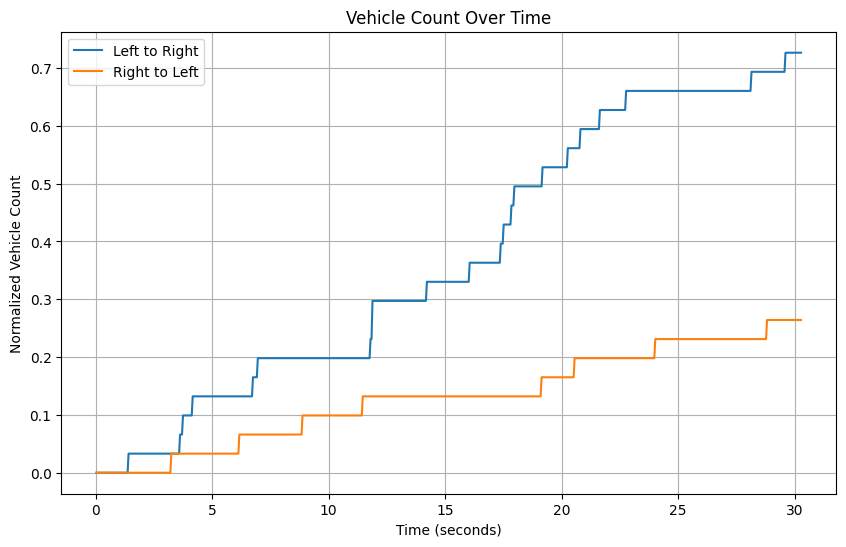

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cap = cv2.VideoCapture("traffic.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames / fps
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=30)

tracked_objects = {}
next_id = 0

line_y = frame_height // 2

left_to_right_count = 0
right_to_left_count = 0

frame_count = 0
times = []
left_to_right_counts = []
right_to_left_counts = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    current_time = frame_count / fps
    
    mask = bg_subtractor.apply(frame)
    
    thresh = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)[1]
    
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    detections = []
    
    for contour in contours:
        if cv2.contourArea(contour) < 500:
            continue
        
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        center_y = y + h // 2
        
        detections.append((center_x, center_y, w, h))
    
    active_tracks = set()
    
    for center_x, center_y, w, h in detections:
        matched = False
        
        for obj_id, obj_data in tracked_objects.items():
            last_x, last_y = obj_data["positions"][-1][:2]
            
            distance = np.sqrt((center_x - last_x)**2 + (center_y - last_y)**2)
            
            if distance < max(w, h) * 0.8:
                tracked_objects[obj_id]["positions"].append((center_x, center_y, w, h))
                tracked_objects[obj_id]["unmatched"] = 0
                active_tracks.add(obj_id)
                matched = True
                
                if len(tracked_objects[obj_id]["positions"]) > 5 and tracked_objects[obj_id]["direction"] is None:
                    first_x = tracked_objects[obj_id]["positions"][0][0]
                    last_x = tracked_objects[obj_id]["positions"][-1][0]
                    
                    if abs(last_x - first_x) > 30:
                        if last_x > first_x:
                            tracked_objects[obj_id]["direction"] = "left_to_right"
                        else:
                            tracked_objects[obj_id]["direction"] = "right_to_left"
                
                if not tracked_objects[obj_id]["counted"] and tracked_objects[obj_id]["direction"] is not None:
                    prev_y = tracked_objects[obj_id]["positions"][-2][1]
                    
                    if (prev_y < line_y and center_y >= line_y) or (prev_y > line_y and center_y <= line_y):
                        if tracked_objects[obj_id]["direction"] == "left_to_right":
                            left_to_right_count += 1
                        else:
                            right_to_left_count += 1
                        
                        tracked_objects[obj_id]["counted"] = True
                
                break
        
        if not matched:
            tracked_objects[next_id] = {
                "positions": [(center_x, center_y, w, h)],
                "direction": None,
                "counted": False,
                "unmatched": 0
            }
            active_tracks.add(next_id)
            next_id += 1
    
    for obj_id in list(tracked_objects.keys()):
        if obj_id not in active_tracks:
            tracked_objects[obj_id]["unmatched"] += 1
            
            if tracked_objects[obj_id]["unmatched"] > 10:
                del tracked_objects[obj_id]
    
    times.append(current_time)
    left_to_right_counts.append(left_to_right_count / duration)
    right_to_left_counts.append(right_to_left_count / duration)

cap.release()

plt.figure(figsize=(10, 6))
plt.plot(times, left_to_right_counts, label='Left to Right')
plt.plot(times, right_to_left_counts, label='Right to Left')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Vehicle Count')
plt.title('Vehicle Count Over Time')
plt.legend()
plt.grid(True)
plt.show()